# Support Vecor Machine (SVM)
<!--
Author: Zhaoqiang SHEN
Date: 2018/08/22
Contact: szqtclx@gmail.com
-->

### SVM 算法特点
优点：泛化（由具体的、个别的扩大为一般的，就是说：模型训练完后的新样本）错误率低，计算开销不大，结果易理解。  
缺点：对参数调节和核函数的选择敏感，原始分类器不加修改仅适合于处理二分类问题。  
使用数据类型：数值型和标称型数据。

In [1]:
import copy
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn import svm

## 线性核SVC

### 硬间隔SVC
对于一个线性可分的训练集，多个平面可以划分数据，只要它们满足：  
${\bf w}^T {\bf x}_i + b \geq +1$, for $y_i = +1$,  
${\bf w}^T {\bf x}_i + b \leq   -1$, for $y_i = -1$.

距离平面最近的两类训练样本称为**支持向量**（让上面两式之一等号成立的点），两异类支持向量到平面距离的和称为**几何间隔**，它等于$2/\|{\bf w} \|$。SVM希望在可以划分数据的平面中去找几何间隔最大者（也就是将最难分的点也尽量分得远一些）。  
因此SVM的**基本型**写为，  
优化目标：$\min_{{\bf w}, b} \frac{1}{2} \| {\bf w} \|^2$  
s.t. $y_i ({\bf w}^T {\bf x}_i+b) \geq 1$, for every $i=1,2,3, \cdots, m.$

利用拉格朗日乘子法，有$L({\bf w}, b, {\bf \alpha}) = \frac{1}{2} \| {\bf w} \|^2 + \sum_i \alpha_i (1-y_i ({\bf w}^T {\bf x}_i+b))$。   
当**强对偶性**成立时（Slater条件：对于凸函数，如果存在一个点使不等式约束严格成立，则满足强对偶性；对于非凸函数情况下通常不成立），主问题与对偶问题的解相等（否则后者小于前者），即$\min_{{\bf w}, b} \max_{\alpha_i} L({\bf w}, b, {\bf \alpha}) = \max_{\alpha_i} \min_{{\bf w}, b} L({\bf w}, b, {\bf \alpha})$，  
其中**对偶问题**为  
$RHS = \boxed {\max_{\alpha} \sum_{i=1}^m \alpha_i - \frac{1}{2} \sum_i \sum_j \alpha_i \alpha_j y_i y_j {\bf x}_i^T {\bf x}_j }$,  
s.t. $\boxed {\sum_i \alpha_i y_i = 0}$, and $\boxed { \alpha_i \geq 0}$.

强对偶同样导致KKT条件成立，  
- stationarity: ${\bf w}=\sum_i \alpha_i y_i {\bf x}_i$,  
- dual feasible: $\alpha_i \geq 0$,  
- prime feasible: $y_i ({\bf w}^T {\bf x}_i+b) \geq 1$, and   
- complementary slackness: $\alpha_i (1-y_i ({\bf w}^T {\bf x}_i+b)) = 0$.  

从KKT条件上来看，对于不在最大间隔边界上的点，其满足$y_i f({\bf x}_i)-1>0$，因此需要$\alpha_i=0$，它们也就对参数没有影响。事实上SVM只与支持向量相关。

### 软间隔SVC
当不能线性可分时（即存在不满足$y_i ({\bf w}^T {\bf x}_i + b) \geq 1$的样本点），我们希望不满足约束者越少越好。则优化目标改写为：  
$\min_{{\bf w}, b} \frac{1}{2} \| {\bf w} \|^2 + C \sum_{i=1}^m \ell(y_i ({\bf w}^T {\bf x}_i + b) )$  
其中，损失函数包括：
- 0/1 损失函数：$\ell_{0/1}(z) = H(-z) $
- 合页(hinge)损失函数：$\ell_{hinge}(z) = \max(0, 1-z)$
- 对数损失函数：$\ell_{exp}(z) = \exp(-z)$
- 对率损失函数：$\ell_{log}(z) = \log_2(1+\exp(-z))$

对于合页损失函数，引入**松弛变量**$\xi_i = \ell_{hinge}(y_i ({\bf w}^T {\bf x}_i + b))$，则优化目标写为：  
$\min_{{\bf w}, b, {\bf \xi}} \frac{1}{2} \| {\bf w} \|^2 + C \sum_{i=1}^m \xi_i$，  
其中，$ \xi_i \geq 0$ and $\xi_i \geq 1-y_i ({\bf w}^T {\bf x}_i + b)$。

得到拉格朗日函数：$L({\bf w}, b, {\bf \xi}, {\bf \alpha}, {\bf \mu}) = \frac{1}{2} \| {\bf w} \|^2 + C\sum_i \xi_i + \sum_i \alpha_i (1-\xi_i-y_i ({\bf w}^T {\bf x}_i+b)) - \sum_i \mu_i \xi_i$。  
它的对偶问题为：
$\max_{\alpha} \sum_{i=1}^m \alpha_i - \frac{1}{2} \sum_i \sum_j \alpha_i \alpha_j y_i y_j {\bf x}_i^T {\bf x}_j $,  
s.t. $\sum_i \alpha_i y_i = 0$, and $\boxed {0 \leq \alpha_i \leq C}$.  
硬间隔SVC是软间隔SVC的$C \to \infty$的一个特例，通过这么取使得前者不存在不满足$y_i ({\bf w}^T {\bf x}_i + b) \geq 1$的样本点。

因为强对偶，所以KKT条件成立：  
- stationarity: ${\bf w}=\sum_i \alpha_i y_i {\bf x}_i$,
- dual feasible: $\alpha_i \geq 0$, and $\mu_i \geq 0$,  
- prime feasible: $1-\xi_i - y_i ({\bf w}^T {\bf x}_i+b) \leq 0$, and $-\xi_i \leq 0$,  
- complementary slackness: $\alpha_i (1-\xi_i-y_i ({\bf w}^T {\bf x}_i+b))=0$, and $\mu_i \xi_i=0$.

由KKT条件可知，
1. 只有满足$1-\xi_i=y_i ({\bf w}^T {\bf x}_i+b)$的向量（支持向量）对参数有影响（落在最大间隔边界及内部的点），即合页损失函数保持了SVM的稀疏性。
2. 由于$\alpha_i+\mu_i=C$，如果某个点有$\alpha_i = C$，则$\mu_i=0$， $\xi_i \geq 0$，因此它可能落在最大间隔内部。如果$0 < \alpha_i < C$，则$\xi_i = 0$，它一定落在最大间隔边界上。

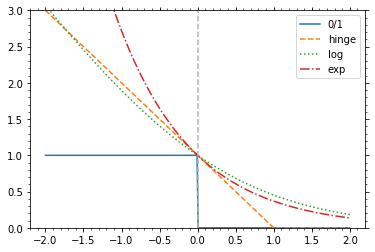

In [2]:
# Loss functions
fg0, ax0 = plt.subplots()

x = np.linspace(-2., 2., 300)
ax0.plot(x, x<0., ls='-', label='0/1')
ax0.plot(x, np.maximum(0., 1.-x), ls='--', label='hinge')
ax0.plot(x, np.log2(1.+np.exp(-x)), ls=':', label='log')
ax0.plot(x, np.exp(-x), ls='-.', label='exp')

ax0.plot([0., 0.], [0., 3.], ls='--', c='0.7')
ax0.set_ylim((0., 3.))
ax0.legend()

### 求解SVC

上述对偶问题是二次规划问题，因此可以用常用的二次规划解法：椭球法(ellipsoid method)，内点法(interior method)，增广拉格朗日法(augmented Lagrangian)，梯度投影法(gradient projection)等。但这些方法运算规模正比于训练样本数，造成很大的运算开销。

#### SMO (Sequential Minimal Optimization)
SMO算法[(Platt98)](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/tr-98-14.pdf)利用了SVC问题的特点使得求解更为高效：它每次选取一对参数$\alpha_i$, $\alpha_j$，因为有$\sum_i \alpha_i y_i = 0$，所以$\alpha_i y_i + \alpha_j y_j = c \equiv -\sum_{k \neq i,j} \alpha_k y_k$，消去对偶问题中的$\alpha_j$，即可得到一个关于$\alpha_i$的二次函数，这个函数的解易得。通过如此反复选取参数做二次规划，目标函数会逐渐增大。因为目标函数是凹的，反复迭代后参数会慢慢收敛。

```
SMO(X, y, C, tol)
1  alpha = zeros(m)
2  while KKT条件在tol程度以上有破坏:
3      选取一对要更新的变量alpha1, alpha2
4      解关于alpha1, alpha2对偶问题的对偶问题，并更新alpha向量
5      更新w, b
```

下面是几点细节：
- 关于求解$\alpha_1$, $\alpha_2$对偶问题：若假设$\alpha'_1=\alpha_1 + \Delta \alpha_1$，则易得
$\Delta \alpha_1 = \frac{1}{y_1 \| {\bf x}_1 - {\bf x}_2\|^2} \left \{ (y_1-y_2)\left[1+\frac{1}{y_1 y_2} \right] + E_2 - E_1 \right \} \overset{|y_i|=1}{=} \frac{y_1 (E_2 - E_1)}{\| {\bf x}_1 - {\bf x}_2 \|^2} $，其中$E_i = y_{{\rm pred},i} - y_i$。

- 关于在软间隔SVC中更新$\alpha_1$和$\alpha_2$：
    <img src="figures/smo1.png" width="50%" height="50%" align=center />
    当$y_1 \neq y_2$时，$\alpha'_1$取值下限：$L=\max (0, \alpha_1-\alpha_2)$，取值上限为：$H=\min (C, C+\alpha_1-\alpha_2)$。左图显示了$0 \leq \alpha'_1 \leq C+\alpha_1-\alpha_2$。  
    当$y_1 = y_2$时，$\alpha'_1$取值下限：$L=\max (0, \alpha_1+\alpha_2-C)$，取值上限为：$H=\min (C, \alpha_1+\alpha_2)$。右图显示了$0 \leq \alpha'_1 \leq \alpha_1+\alpha_2$。  

- 关于求解b的值：支持向量满足$y ({\bf w}^T{\bf x}+b) = 1$。计算b时，我们考虑所有支持向量的贡献：$\sum_{s \in S} \left [({\bf w}^T {\bf x}_s + b)  - 1/y_s \right] = 0$。

- 关于选取要更新的$\alpha_1$和$\alpha_2$：SMO算法依次选取$\alpha_1$和$\alpha_1$。$\alpha_1$对应的点需要不满足KKT条件，先选择取非边界的点，否则遍历整个集合。$\alpha_2$选择使两变量对应的$E_2 - E_1$最大。

In [3]:
!head datasets/MLiA/Ch06/testSet.txt

In [4]:
# 一组线性可分的数据
input_data = np.loadtxt('datasets/MLiA/Ch06/testSet.txt')
X1 = input_data[:, :-1]
y1 = input_data[:, -1]

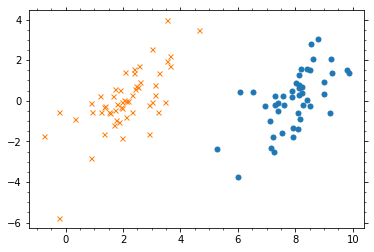

In [5]:
fg1, ax1 = plt.subplots()
ax1.plot(X1[y1>0, 0], X1[y1>0, 1], marker='o', ms=5, ls='None')
ax1.plot(X1[y1<0, 0], X1[y1<0, 1], marker='x', ms=5, ls='None')

In [6]:
"""
SMO算法

参考：
1. 机器学习实战, pp.94-105
2. 统计学习方法, pp.128-131
3. Platt1998
"""

inf = float('inf')

class linearSVC:
    """
    Linear SVC
    """
    
    def __init__(self, C=1., tol=1e-3):
        """
        Parameters
        -------------
        C : scalar, >0.
            constant to control the regularization
        tol : scalar, >0, default: 1e-3
            tolerence of the fitting
        """
        assert C > 0. and tol > 0.
        self.C_, self.tol_ = C, tol
        self.w_, self.b_ = None, 0.
        
    def __call__(self, X):
        """
        Linear SVC model
        
        Parameters
        -------------
        X : (m', n) array
            input features

        Returns
        ---------
        y_pred : (m', 1)
            predicted labels of input features
        """
        return self.predict(X)
        
    def weight(self, alpha, X_data, y_data):
        """
        Parameters
        -------------
        alpha : (m, 1) array, 0<=alpha<=C
            dual parameters
        X_data : (m, n) array
            training data
        y_data : (m, 1) array, =+/-1
            the label of training data

        Returns
        ---------
        w: (n, 1) array
            weight vector
        """
        self.w_ = (alpha*y_data*X_data).sum(axis=0, keepdims=True).T
        return self.w_

    def predict(self, X):
        """
        Linear SVC model
        
        Parameters
        -------------
        X : (m', n) array
            input features

        Returns
        ---------
        y_pred : (m', 1)
            predicted labels of input features
        """
        assert self.w_ is not None
        return X@self.w_ + self.b_ # np.dot(X, w) + b

    @staticmethod
    def support_vector_indices(alpha):
        """
        Find the indices of support vectors, which satisfies
        \alpha_i != 0. due to the KKT condition.

        Parameters
        -------------
        alpha : (m, 1) array, 0<=alpha<=C
            dual parameters

        Returns
        ---------
        indices : array of non-negative integers
            the index of support vectors in the data
        """
        return np.nonzero(alpha>1.e-7)[0]
    
    def bias(self, alpha, X_data, y_data):
        """
        Calculate the bias and weight terms of the model.

        Parameters
        -------------
        alpha : (m, 1) array, 0<=alpha<=C
            dual parameters
        X_data : (m, n) array
            training data
        y_data : (m, 1) array, =+/-1
            the label of training data

        Returns
        ---------
        b : scalar
            the bias/interception of linear model
        """
        assert self.w_ is not None
        idxs = self.support_vector_indices(alpha)
        X_sv, y_sv = X_data[idxs, :], y_data[idxs, :]
        self.b_ = sum(1./y_sv - X_sv@self.w_) / len(idxs)
        return self.b_
    
    @staticmethod
    def eta(xi, xj):
        """
        Calculate eta=|| \Phi(xi) - \Phi(xj) ||^2
        """
        return ((xi-xj)**2).sum() # for kenerlized SVM, eta=Kii+Kjj-2*Kij
    
    def update_alpha(self, alpha, i, j, X_data, y_data):
        """
        Update the dual parameters based on SMO algorithm

        Parameters
        -------------
        alpha : (m, 1) array, >=0.
            dual parameters
        i, j : integer, >=0, i != j
            the term of alpha needed to be update
        X_data : (m, n) array
            training data
        y_data : (m, 1) array, =+/-1
            the label of training data

        Returns
        ---------
        is_updated : bool
            whether the update is performed
        """
        if i<0 or j<0 or i==j:
            return False

        # calculate errors for i, j
        xi, yi = X_data[i:i+1, :], y_data[i, 0] # xi in (1, n), yi is scalar
        yi_pred = self.predict(xi) # b is canceled out, so here we just use b=0
        Ei = yi_pred - yi

        xj, yj = X_data[j:j+1, :], y_data[j, 0]
        yj_pred = self.predict(xj)
        Ej = yj_pred - yj

        # Compute L, H
        alpha_i, alpha_j = alpha[i, 0], alpha[j, 0]
        if yi*yj < 0:
            L = max(0., alpha_i-alpha_j)
            H = min(self.C_, self.C_+alpha_i-alpha_j)
        else:
            L = max(0., alpha_i+alpha_j-self.C_)
            H = min(self.C_, alpha_i+alpha_j)
        if L >= H:
            #print("[skipped] L >= H")
            return False

        # compute eta
        eta = self.eta(xi, xj)
        if eta <= 0.:
            #print('[skipped] eta <= 0')
            return False
        
        # new alphas
        dalpha_i = yi/eta * (Ej - Ei)
        alpha_i_new = np.clip(alpha_i+dalpha_i, a_min=L, a_max=H) # L <= alpha_new <= H
        if abs(alpha_i_new-alpha_i) <= 1e-6*(alpha_i_new + alpha_i + 1e-6):
            #print('[skipped] not enough update for alpha')
            return False
        alpha_j_new = (alpha_i-alpha_i_new)*yi*yj + alpha_j # a1y1 + a2y2 = a'1y1 + a'2y2, |yi|=1

        # update parameters
        alpha[i] = alpha_i_new
        alpha[j] = alpha_j_new
        self.weight(alpha, X_data, y_data)
        self.bias(alpha, X_data, y_data)
        return True
    
    def examine(self, i, alpha, X_data, y_data):
        """
        Do one-step fitting given the first index
        
        Parameters
        -------------
        i : integer, >=0
            the first index
        alpha : (m, 1) array, >=0.
            dual parameters
        X_data : (m, n) array
            training data
        y_data : (m, 1) array, =+/-1
            the label of training data
            
        Returns
        ---------
        is_fitted : bool
        """
        m = X_data.shape[0]
        y_pred = self.predict(X_data)
        
        ai= alpha[i, 0]
        ri = y_data[i, 0]*y_pred[i, 0]-1.
        
        # when KKT condition does not satisfy
        # KKT: 0<a<C, y*y_pred=1; a=0, y*y_pred>=1; a=C, y*y_pred<=1
        if (ai<self.C_ and ri<-self.tol_) or (ai>0 and ri>self.tol_):
            # Heuristic:
            # 1. nonbound points are more likely to be updated, while those
            #    at boundary are kept at the same position
            # 2. dalpha is larger when |E_i - E_j| is larger
            nonbds = set(np.nonzero((alpha>0) & (alpha<self.C_))[0])
            if nonbds:
                errs = y_pred-y_data
                j = np.abs(errs-errs[i]).argmax()
                if self.update_alpha(alpha, i, j, X_data, y_data):
                    return True

            for j in nonbds:
                if self.update_alpha(alpha, i, j, X_data, y_data):
                    return True
                
            for j in range(m):
                if not j in nonbds and self.update_alpha(alpha, i, j, X_data, y_data):
                    return True
        return False

    def fit(self, X_data, y_data):
        """
        Fit the linear SVC model with SMO algorithm
        
        Parameters
        -------------
        X_data : (m, n) array
            training data
        y_data : (m, 1) array, =+/-1
            the label of training data
            
        Returns
        ---------
        alpha : (m, 1) array, 0<=alpha<=C
            dual parameters
        """
        m, n = X_data.shape
        self.w_ = np.zeros((n, 1))
        self.b_ = 0.
        alpha = np.zeros((m, 1))

        y_data = y_data.reshape((-1, 1))
        
        it = 0
        num_change = 0
        examine_all = True
        while (num_change>0 or examine_all):
            if examine_all:
                arridx = range(m) # find the points break KKT conditions
            else:
                arridx = np.nonzero((alpha>0)&(alpha<self.C_))[0]

            num_change = 0 # the number of pairs of changed alphas in this pass    
            for i in range(m):
                num_change += self.examine(i, alpha, X_data, y_data)

            if examine_all:
                examine_all = False
            elif num_change == 0:
                examine_all = True

            print('iter={}, loss={}'.format(it, self.loss2(alpha, X_data, y_data)))
            it += 1
        return alpha
    
    @staticmethod
    def loss2(alpha, X_data, y_data):
        """
        Parameters
        -------------
        alpha : (m, 1) array, >=0.
            dual parameters
        X_data : (m, n) array
            training data
        y_data : (m, 1) array, =+/-1
            the label of training data
            
        Returns
        ---------
        loss : scalar
        """
        ws = alpha*y_data*X_data
        return alpha.sum() - (ws.T@ws).sum()
    
    def loss(self, X_data, y_data):
        """
        Parameters
        -------------
        X_data : (m, n) array
            training data
        y_data : (m, 1) array, =+/-1
            the label of training data

        Returns
        ---------
        loss : scalar
        """
        y_pred = self.predict(X_data)
        return 0.5*(self.w_**2).sum() + self.C_*np.maximum(0., 1.-y_data*y_pred).sum()

In [7]:
# wrap up all the components
mysvc = linearSVC(C=1., tol=1e-6)
alpha = mysvc.fit(X_data=X1, y_data=y1)

iter=0, loss=-0.39146757875752386
iter=1, loss=-1.0502367724389323
iter=2, loss=-1.3916067871948512
iter=3, loss=-1.8192752476547855
iter=4, loss=-2.034726726231521
iter=5, loss=-2.2178503117704507
iter=6, loss=-2.3788282840236974
iter=7, loss=-2.526011286821447
iter=8, loss=-2.665297897605459
iter=9, loss=-2.80065670377048
iter=10, loss=-2.934689049168487
iter=11, loss=-3.069074939158446
iter=12, loss=-3.2048898823975915
iter=13, loss=-3.342818747088997
iter=14, loss=-3.4832962108515426
iter=15, loss=-3.626597580864691
iter=16, loss=-3.772896986933361
iter=17, loss=-3.92230446280991
iter=18, loss=-4.07488949391425
iter=19, loss=-4.230695938286101
iter=20, loss=-4.38975146776442
iter=21, loss=-4.552073536107161
iter=22, loss=-4.717673149089623
iter=23, loss=-4.88655724489043
iter=24, loss=-5.058730196433915
iter=25, loss=-5.234194759256813
iter=26, loss=-5.412952669371459
iter=27, loss=-5.595005020269355
iter=28, loss=-5.7803525005981085
iter=29, loss=-5.968995543968777
iter=30, loss=-

In [8]:
mysvc.w_, mysvc.b_

(array([[ 0.81439535],
        [-0.27249991]]), array([-3.83784491]))

In [9]:
idxs = mysvc.support_vector_indices(alpha)
xs = X1[idxs, :]
print('Support Vectors:')
print(xs)
print('y*alpha:')
print(y1[idxs]*alpha[idxs, 0])
ax1.plot(xs[:, 0], xs[:, 1], ls='None', marker='*', label='support vectors', c='C4')

Support Vectors:
[[ 4.658191  3.507396]
 [ 3.457096 -0.082216]
 [ 6.080573  0.418886]]
y*alpha:
[-0.12738994 -0.2413584   0.36874833]


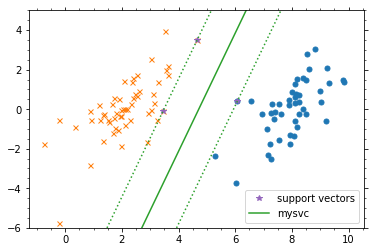

In [10]:
x_ = np.array([0., 10.])
y_ = -(mysvc.b_+ mysvc.w_[0, 0]*x_)/mysvc.w_[1, 0]
y1_ = -(mysvc.b_-1+ mysvc.w_[0, 0]*x_)/mysvc.w_[1, 0]
y2_ = -(mysvc.b_+1+ mysvc.w_[0, 0]*x_)/mysvc.w_[1, 0]
ax1.plot(x_, y_, ls='-', c='C2', label='mysvc')
ax1.plot(x_, y1_, ls=':', c='C2')
ax1.plot(x_, y2_, ls=':', c='C2')

ax1.set_ylim((-6, 5))
ax1.legend()
fg1

#### sklearn
`scikit-learn`中提供了`libsvm`和`liblinear`两个接口用来求解线性SVC问题。前者使用了二次规划方法，时间复杂度在$O(n\,m^2)$到$O(n \, m^3)$之间；而后者专门解决线性SVM问题，时间复杂度为$O(m)$[(scikit-learn.org)](http://scikit-learn.org/stable/modules/svm.html#complexity)。

In [16]:
svc = svm.LinearSVC(C=1., loss='hinge') # liblinear
svc.fit(X1, y1)
print(svc.coef_, svc.intercept_) # w1, w2, b # excuse me?!

[[ 0.48886972 -0.23302279]] [-2.45984863]


In [12]:
svc2 = svm.SVC(kernel='linear') # libsvm
svc2.fit(X1, y1)
print(svc2.coef_, svc2.intercept_) # w1, w2, b

[[ 0.81444269 -0.27274371]] [-3.83775658]


In [13]:
svc2.support_vectors_

array([[ 4.658191,  3.507396],
       [ 3.457096, -0.082216],
       [ 6.080573,  0.418886]])

In [14]:
svc2.dual_coef_

array([[-0.12746518, -0.24133564,  0.36880082]])

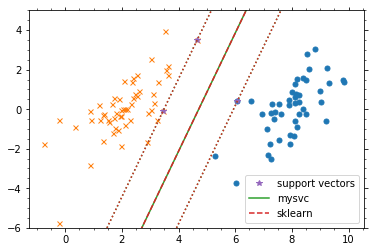

In [15]:
y_ = -(svc2.intercept_+svc2.coef_[0, 0]*x_)/svc2.coef_[0, 1]
y1_ = -(svc2.intercept_-1.+svc2.coef_[0, 0]*x_)/svc2.coef_[0, 1]
y2_ = -(svc2.intercept_+1.+svc2.coef_[0, 0]*x_)/svc2.coef_[0, 1]
ax1.plot(x_, y_, ls='--', c='C3', label='sklearn')
ax1.plot(x_, y1_, ls=':', c='C3')
ax1.plot(x_, y2_, ls=':', c='C3')
ax1.set_ylim((-6, 5))
ax1.legend()
fg1

## 核技巧
如在[线性回归](1_LinearRegression.ipynb#核技巧)中所述：通过使用核函数，我们隐式的在高维特征空间中做线性划分。

## SVR